**In this Notebook we are going to train a neural network using pytorch**. we will be going through the following steps:
1. Preprocess CSV files and convert the data to Tensors
2. Build your own Neural Network model with PyTorch
3. Use a loss function and an optimizer to train your model
4. Evaluate your model and learn about the perils of imbalanced classification

**Data**
Our dataset contains daily weather information from multiple Australian weather stations. We’re about to answer a simple question. Will it rain tomorrow?

The data is hosted on [kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) and created by Joe Young. I’ve uploaded the dataset to Google Drive. Let’s get it:

## Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

Bellow is the way to load your dataset from your computer to google colab and also how to read the loaded dataset with pandas.

In [ ]:
# Uncomment the following 2 lines if you are using google colab
# from google.colab import files


# uploaded = files.upload()


In [ ]:

import io

df = pd.read_csv(io.BytesIO(uploaded['weatherAUS.csv']))
df.head()

we want to see if there are missing values on the dataset we will be using isna function from pandas and the sum to get the sum of missing values of each rows

In [ ]:
df.isna().sum()

In [ ]:
# Check if there any missing values in train set
ax = df.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Let just have a look at the percentage of missing values for each features

In [ ]:
df.info()

Distribution of the target variable

In [ ]:
df.RainTomorrow.value_counts().plot(kind='bar')

For the purpose of this demo we are going to drop each row with missing values
**Note**: This is not the best way you have to handle missing values where the percentage of missing values is less than 80% 

In [ ]:
df = df.dropna(how='any')
df.isna().sum()

In [ ]:
df.shape

As we can see after droping missing values we lost a lot of data after looking at the shape of the data we can notice that.

I want **encode** all my categorical features but here I have my target which is **RainTomorrow** that contain 2 classes so we are removing it temporary from our original data we will add it after encoding all categorical features. 
I am think of renaming the ***RainTomorrow*** to ***Target***

In [ ]:
train = df.drop('RainTomorrow',1)

In [ ]:


train = pd.get_dummies(train)
train.head()

we have used get_dummies and we didn't use drop first so it will add so extra featrues to our dataset. That is the reason why I removed the Target. For exemple if we 2 classes A and B then it will add features_A and featrues_B in our dataset which  I didn't want for my target.

In [ ]:
df.shape

we are going to encode our target using the label encoder from sklearn. To learn more about  label encoder click [Label Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
train['Target'] = df.RainTomorrow

In [ ]:
encoder = LabelEncoder()
train.Target = encoder.fit_transform(train.Target)
train.Target.value_counts()

In [ ]:
train.Target.value_counts().plot(kind='bar')

Things are not looking good. About 78% of the data points have a non-rainy day for tomorrow. This means that a model that predicts there will be no rain tomorrow will be correct about 78% of the time.
This concept is known as **unbalanced** data but we are not going to handle it right now.

Now we select our features and the target for the model.
1. X is an nd arrays in this case features
2. y is a 1d array target

In [ ]:
X = train.drop('Target',1).values
y = train.Target.values

We want to now split the data into train and test set so for that we are going to use train_test_split from **sklearn**

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=RANDOM_SEED)

In [ ]:
X_train.shape , y_train.shape

We need to Standarize our data to put it to the same scale we will be using **StandardScaler** form sklearn this is what the standardscaler is doing:
Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

    z = (x - u) / s

learn more about standardscaler here:[Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

As we are going to use **pytorch** we have to convert our numpy array to a Tensor for this we are going to use the **torch.Tensor**
[pytorch documentation](https://pytorch.org/docs/stable/tensors.html)

In [ ]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [ ]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)

## Building neural network
We’ll build a simple Neural Network (NN) that tries to predicts if it will rain tomorrow or not.<br>
The output will be binary meaning 0 or 1. <br>
One easy way to build the NN with PyTorch is to create a class that inherits **from torch.nn.Module**

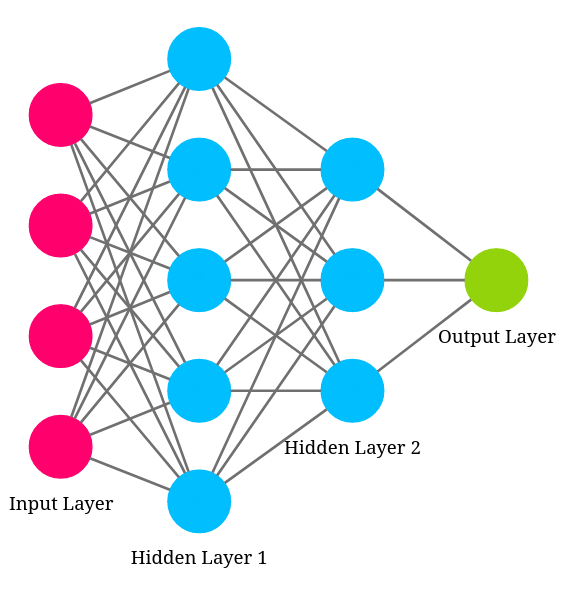

In [ ]:
n_samples, n_features = X_train.shape
n_features

For building the model we will be using the following activation functions: <br> 
1. Relu: Formula ReLU(x)=max(0,x)
2. Sigmoid: Sigmoid(x)=1+exp(−x)1​

Read more about these activation fucntion from the documentations <br>
1. [Relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
2. [Sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)

In [ ]:
class Net(nn.Module):

  def __init__(self, n_features):

    super(Net, self).__init__()

    self.fc1 = nn.Linear(n_features, 5)

    self.fc2 = nn.Linear(5, 3)

    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):

    x = F.relu(self.fc1(x))

    x = F.relu(self.fc2(x))

    x = torch.sigmoid(self.fc3(x))
    return x

net = Net(X_train.shape[1])


Training the model we are going to use Binary cross-entropy loss <br>
Creates a criterion that measures the Binary Cross Entropy between the target and the output in this case read more about it [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

In [ ]:
criterion = nn.BCELoss()

For the optimizer we are going to use Adam optimizer. <br>
Read more about [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

As google colab provod GPU we are going to do it on GPU in this case

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)

y_train = y_train.to(device)

X_test = X_test.to(device)

y_test = y_test.to(device)

net = net.to(device)

criterion = criterion.to(device)

This function is to calculate the accuracy of our model when we are training the model

In [ ]:
def calculate_accuracy(y_true, y_pred):

  predicted = y_pred.ge(.5).view(-1)

  return (y_true == predicted).sum().float() / len(y_true)

In [ ]:
def round_tensor(t, decimal_places=3):

  return round(t.item(), decimal_places)

for epoch in range(1000):

    y_pred = net(X_train)

    y_pred = torch.squeeze(y_pred)

    train_loss = criterion(y_pred, y_train)

    if epoch % 100 == 0:

      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)

      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)

      print(

f'''epoch {epoch}

Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}

Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}

''')

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

In [ ]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()

y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))